In [2]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



In [3]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final=pd.read_sql_query(""" SELECT * FROM Reviews""", conn) 

In [4]:
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final= final.sort_values(by = "Time")

In [5]:
from sklearn.model_selection import train_test_split
X = final["CleanedText"]
y = final["Score"]
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle='false')
print(X_train.shape, y_train.shape, x_test.shape)

(137165,) (137165,) (58785,)


In [8]:
bow = CountVectorizer(binary=True)
X_train = bow.fit_transform(X_train)
X_train

<137165x44121 sparse matrix of type '<class 'numpy.int64'>'
	with 4364956 stored elements in Compressed Sparse Row format>

In [9]:
x_test = bow.transform(x_test)
x_test.shape
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)


In [10]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
nb = BernoulliNB()
# neigh = np.arange(1,100,2)
param_grid = {'alpha':np.arange(1,30,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = GridSearchCV(nb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   40.5s finished


Best HyperParameter:  {'alpha': 1}
Best Accuracy: 86.90%



The accuracy of the nb for alpha = 1 is 88.197669%

The f1 score of the nb for alpha = 1 is 76.313522%

The recall score of the nb for alpha = 1 is 74.958576%

The precision score of the nb for alpha = 1 is 77.960623%


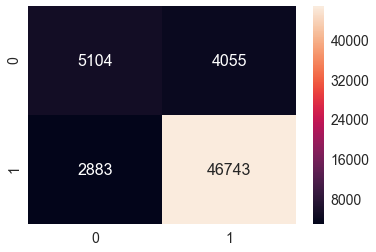

In [11]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score

# instantiate learning model k = optimal_k
nb = BernoulliNB(alpha=1)

# fitting the model
nb.fit(X_train, y_train)

# predict the response
pred = nb.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the nb for alpha = %d is %f%%' % (1, acc))
print('\nThe f1 score of the nb for alpha = %d is %f%%' % (1, f1))
print('\nThe recall score of the nb for alpha = %d is %f%%' % (1, r))
print('\nThe precision score of the nb for alpha = %d is %f%%' % (1, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [12]:
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
pos_class_prob_sorted = pos_class_prob_sorted[::-1]
neg_class_prob_sorted = neg_class_prob_sorted[::-1]
print('\nTop 10 features for  positive and negative class')
print(np.take(bow.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(bow.get_feature_names(), pos_class_prob_sorted[:10]))


Top 10 features for  positive and negative class
['tast' 'like' 'product' 'one' 'would' 'tri' 'good' 'flavor' 'buy' 'get']
['like' 'tast' 'love' 'good' 'great' 'flavor' 'one' 'use' 'tri' 'product']



The accuracy of the nb for alpha = 1 is 90.642171%

The f1 score of the nb for alpha = 1 is 81.114284%

The recall score of the nb for alpha = 1 is 79.348897%

The precision score of the nb for alpha = 1 is 83.283987%


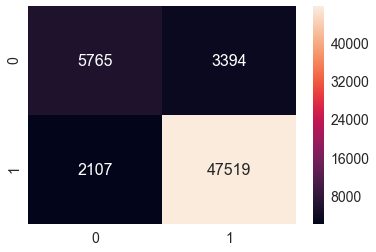

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
# instantiate learning model k = optimal_k
nb = MultinomialNB(alpha=1)

# fitting the model
nb.fit(X_train, y_train)

# predict the response
pred = nb.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the nb for alpha = %d is %f%%' % (1, acc))
print('\nThe f1 score of the nb for alpha = %d is %f%%' % (1, f1))
print('\nThe recall score of the nb for alpha = %d is %f%%' % (1, r))
print('\nThe precision score of the nb for alpha = %d is %f%%' % (1, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [15]:
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
pos_class_prob_sorted = pos_class_prob_sorted[::-1]
neg_class_prob_sorted = neg_class_prob_sorted[::-1]
print('\nTop 10 features for  positive and negative class')
print(np.take(bow.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(bow.get_feature_names(), pos_class_prob_sorted[:10]))


Top 10 features for  positive and negative class
['tast' 'like' 'product' 'one' 'would' 'tri' 'good' 'flavor' 'buy' 'get']
['like' 'tast' 'love' 'good' 'great' 'flavor' 'one' 'use' 'tri' 'product']


In [21]:
X = final["CleanedText"]
y = final["Score"]
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,shuffle='false')
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(137165,) (58785,) (137165,) (58785,)


In [22]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)

In [23]:
x_test = tf_idf_vect.transform(x_test)


In [19]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
nb = BernoulliNB()
# neigh = np.arange(1,100,2)
param_grid = {'alpha':np.arange(1,30,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = GridSearchCV(nb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.1min finished


Best HyperParameter:  {'alpha': 29}
Best Accuracy: 84.06%



The accuracy of the nb for alpha = 29 is 84.344646%

The f1 score of the nb for alpha = 29 is 46.881622%

The recall score of the nb for alpha = 29 is 50.431987%

The precision score of the nb for alpha = 29 is 63.003251%


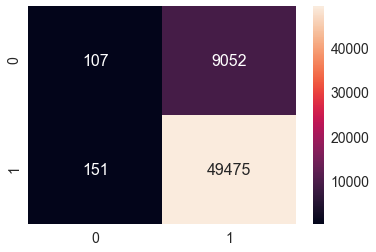

In [24]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score

# instantiate learning model k = optimal_k
nb = BernoulliNB(alpha=29)

# fitting the model
nb.fit(X_train, y_train)

# predict the response
pred = nb.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the nb for alpha = %d is %f%%' % (29, acc))
print('\nThe f1 score of the nb for alpha = %d is %f%%' % (29, f1))
print('\nThe recall score of the nb for alpha = %d is %f%%' % (29, r))
print('\nThe precision score of the nb for alpha = %d is %f%%' % (29, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [25]:
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
pos_class_prob_sorted = pos_class_prob_sorted[::-1]
neg_class_prob_sorted = neg_class_prob_sorted[::-1]
print('\nTop 10 features for  positive and negative class')
print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[:10]))


Top 10 features for  positive and negative class
['tast' 'like' 'product' 'one' 'would' 'tri' 'good' 'flavor' 'buy' 'get']
['like' 'tast' 'love' 'good' 'great' 'flavor' 'one' 'use' 'tri' 'product']



The accuracy of the nb for alpha = 1 is 85.443566%

The f1 score of the nb for alpha = 1 is 52.569704%

The recall score of the nb for alpha = 1 is 53.473351%

The precision score of the nb for alpha = 1 is 89.610766%


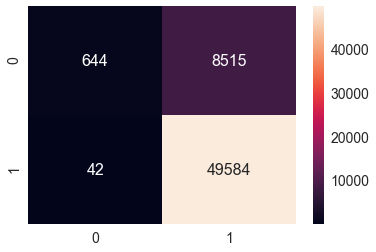

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
# instantiate learning model k = optimal_k
nb = MultinomialNB(alpha=1)

# fitting the model
nb.fit(X_train, y_train)

# predict the response
pred = nb.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100

print('\nThe accuracy of the nb for alpha = %d is %f%%' % (1, acc))
print('\nThe f1 score of the nb for alpha = %d is %f%%' % (1, f1))
print('\nThe recall score of the nb for alpha = %d is %f%%' % (1, r))
print('\nThe precision score of the nb for alpha = %d is %f%%' % (1, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [28]:
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
pos_class_prob_sorted = pos_class_prob_sorted[::-1]
neg_class_prob_sorted = neg_class_prob_sorted[::-1]
print('\nTop 10 features for  positive and negative class')
print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[:10]))


Top 10 features for  positive and negative class
['tast' 'like' 'product' 'coffe' 'would' 'flavor' 'one' 'tri' 'buy'
 'order']
['great' 'love' 'good' 'tast' 'like' 'coffe' 'flavor' 'tea' 'product'
 'use']


In [29]:
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')

from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Hyper parameter", "accuracy", "f1 score","recall","precision score"]
x.add_row(["BERNOULLI BOW", 1, 86.67, 73.77,71.83,76.55])
x.add_row(["MULTINOMIAL BOW", 1, 89.59, 80.09,78.35,82.28])
x.add_row(["BERNOULLI TFIDF", 11, 83.3, 45.44,49.99,41.65])
x.add_row(["MULTINOMIAL TFID", 11, 83.3, 45.44,50,41.65])
print(x)



+------------------+-----------------+----------+----------+--------+-----------------+
|      Model       | Hyper parameter | accuracy | f1 score | recall | precision score |
+------------------+-----------------+----------+----------+--------+-----------------+
|  BERNOULLI BOW   |        1        |  86.67   |  73.77   | 71.83  |      76.55      |
| MULTINOMIAL BOW  |        1        |  89.59   |  80.09   | 78.35  |      82.28      |
| BERNOULLI TFIDF  |        11       |   83.3   |  45.44   | 49.99  |      41.65      |
| MULTINOMIAL TFID |        11       |   83.3   |  45.44   |   50   |      41.65      |
+------------------+-----------------+----------+----------+--------+-----------------+
